# Step 1: Import Required Libraries

This cell imports all necessary libraries for data manipulation, visualization, and modeling.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Step 2: Load the Data

Load all sheets from the Excel file and display a preview of key datasets.

In [ ]:
# Step 2: Load the Data

# Define file path
file_path = 'HrData.xlsx'

# Load sheets into DataFrames
employee_df = pd.read_excel(file_path, sheet_name='Employee')
performance_df = pd.read_excel(file_path, sheet_name='PerformanceRating')
education_level_df = pd.read_excel(file_path, sheet_name='EducationLevel')
rating_level_df = pd.read_excel(file_path, sheet_name='RatingLevel')
satisfied_level_df = pd.read_excel(file_path, sheet_name='SatisfiedLevel')

# Convert ReviewDate to datetime
performance_df['ReviewDate'] = pd.to_datetime(performance_df['ReviewDate'])

# Display previews
print('Employee Data:')
print(employee_df.head())

print('\nPerformance Rating Data:')
print(performance_df.head())

Employee Data:
  EmployeeID   FirstName LastName      Gender  Age BusinessTravel  \
0  3012-1A41    Leonelle    Simco      Female   30    Some Travel   
1  CBCB-9C9D     Leonerd    Aland        Male   38    Some Travel   
2  95D7-1CE9       Ahmed    Sykes        Male   43    Some Travel   
3  47A0-559B  Ermentrude   Berrie  Non-Binary   39    Some Travel   
4  42CC-040A       Stace   Savege      Female   29    Some Travel   

        Department  DistanceFromHome State                Ethnicity  ...  \
0            Sales                27    IL                    White  ...   
1            Sales                23    CA                    White  ...   
2  Human Resources                29    CA  Asian or Asian American  ...   
3       Technology                12    IL                    White  ...   
4  Human Resources                29    CA                    White  ...   

   MaritalStatus  Salary StockOptionLevel OverTime   HireDate  Attrition  \
0       Divorced  102059             

# Step 3: Performance GAP Analysis

Objective: Identify the gap between current and desired performance. Here we use the latest performance review per employee and compare each employee's ManagerRating to the average for their JobRole.

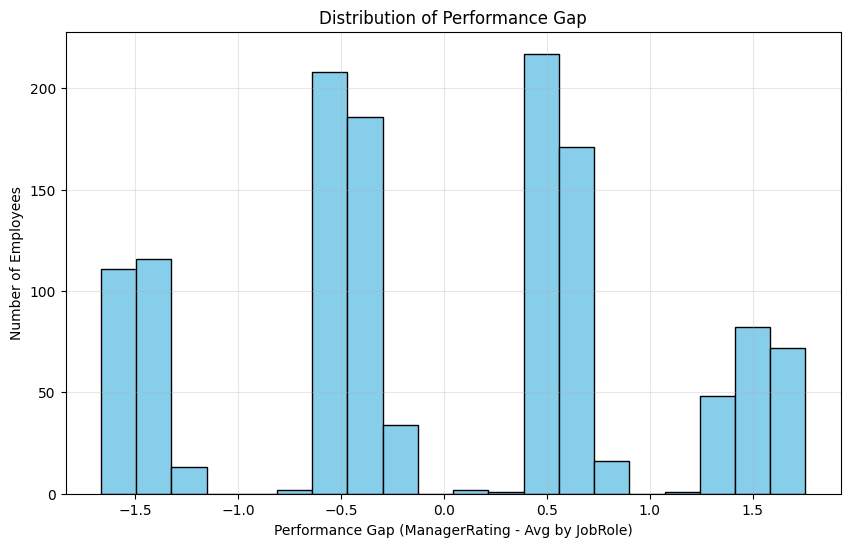

Percentage of employees performing below their job role average: 45.58%
Correlation between Performance Gap and TrainingOpportunitiesTaken: 0.01


In [33]:
# Get the most recent performance review per employee
latest_performance = performance_df.loc[performance_df.groupby('EmployeeID')['ReviewDate'].idxmax()]

# Merge the latest performance review with employee data
merged_df = pd.merge(employee_df, latest_performance, on='EmployeeID', how='left')

# Calculate average ManagerRating per JobRole
avg_rating_by_role = merged_df.groupby('JobRole')['ManagerRating'].mean()

# Compute the performance gap per employee (ManagerRating - average for their job role)
merged_df['Gap'] = merged_df['ManagerRating'] - merged_df['JobRole'].map(avg_rating_by_role)

# Visualize the distribution of performance gaps
plt.figure(figsize=(10, 6))
plt.hist(merged_df['Gap'].dropna(), bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Performance Gap')
plt.xlabel('Performance Gap (ManagerRating - Avg by JobRole)')
plt.ylabel('Number of Employees')
plt.grid(True, alpha=0.3)
plt.show()

# Calculate percentage of employees with a negative gap
negative_gap_pct = (merged_df['Gap'] < 0).mean() * 100
print(f"Percentage of employees performing below their job role average: {negative_gap_pct:.2f}%")

# Explore correlation with training opportunities taken (if column exists in performance_df)
if 'TrainingOpportunitiesTaken' in merged_df.columns:
    correlation = merged_df['Gap'].corr(merged_df['TrainingOpportunitiesTaken'])
    print(f"Correlation between Performance Gap and TrainingOpportunitiesTaken: {correlation:.2f}")
else:
    print("Column 'TrainingOpportunitiesTaken' not found in merged data.")

# Step 4: Training GAP Analysis

Objective: Calculate the gap between available and attended training opportunities and identify the top 10 employees with the largest training gaps.

In [34]:
# Step 4: Training GAP Analysis

# Objective: Calculate the gap between available and attended training opportunities 
# and identify the top 10 employees with the largest training gaps.

# Calculate the training gap
performance_df['TrainingGap'] = performance_df['TrainingOpportunitiesWithinYear'] - performance_df['TrainingOpportunitiesTaken']

# Summarize training gaps
gap_summary = performance_df['TrainingGap'].describe()
print('\nTraining Gap Statistics:\n', gap_summary)

# Extract employees with the largest training gaps (Top 10)
top_training_gaps = performance_df.sort_values(by='TrainingGap', ascending=False).head(10)

# Retrieve their details from the Employee table
df_employee_selected = employee_df[employee_df['EmployeeID'].isin(top_training_gaps['EmployeeID'])]

# Merge performance data with employee details
df_gap_analysis = pd.merge(top_training_gaps, df_employee_selected, on='EmployeeID', how='left')

# Select important columns
df_gap_analysis = df_gap_analysis[['EmployeeID', 'FirstName', 'LastName', 'Department', 
                                   'TrainingOpportunitiesWithinYear', 'TrainingOpportunitiesTaken', 'TrainingGap']]

# Display the top 10 employees in need of training
print('\nTop 10 Employees in Need of Training:\n', df_gap_analysis)


Training Gap Statistics:
 count    6709.000000
mean        1.147116
std         1.014636
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         3.000000
Name: TrainingGap, dtype: float64

Top 10 Employees in Need of Training:
   EmployeeID FirstName    LastName       Department  \
0  3EB2-9111    Ginger      Blinde       Technology   
1  2E72-4BF1     Grace      Gohier            Sales   
2  5468-EEE1    Forbes     Toretta       Technology   
3  10E9-4C86  Ignacius    Dockrill       Technology   
4  D676-4ECC  Florenza      Nesbit       Technology   
5  2B7A-9C73   Bryanty  Wickersley       Technology   
6  B6EC-313E    Corbin      Gooddy  Human Resources   
7  7749-B277     Caryl    Roycroft  Human Resources   
8  1799-5B3F     Howey      Woolis            Sales   
9  819A-2C9C   Hillary      Atchly       Technology   

   TrainingOpportunitiesWithinYear  TrainingOpportunitiesTaken  TrainingGap  
0                                3             

# Step 5: 9-Box Grid Analysis

Objective: Place employees in a 3x3 grid based on their current performance and future potential. 
For current performance we use ManagerRating; for future potential, we compute the trend (slope) of ManagerRating over time using linear regression.

/tmp/ipykernel_872422/3655308779.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  slopes = performance_df.groupby('EmployeeID').apply(calculate_slope)
/tmp/ipykernel_872422/3655308779.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_df['PotentialCategory'] = pd.qcut(valid_df['Slope'], 3, labels=['Low', 'Average', 'High'])


9-Box Grid Distribution:
PotentialCategory    Low  Average  High
PerformanceCategory                    
Average              171      127    76
High                  61      179   282
Low                  136       61    10


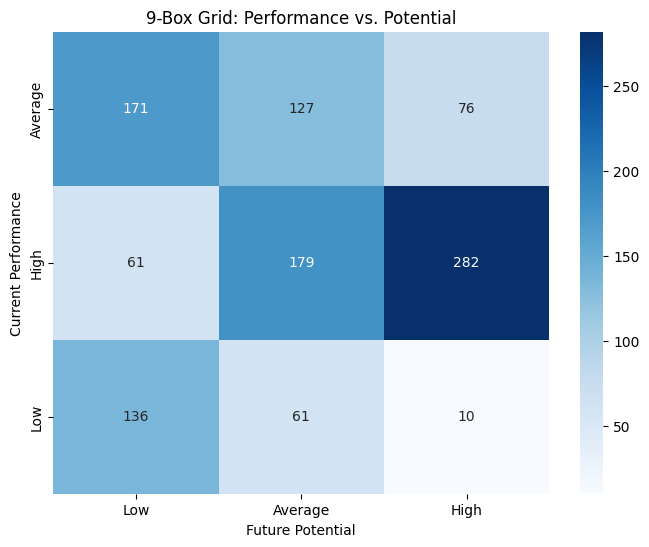

In [35]:
# Function to calculate the slope of ManagerRating over time for each employee
def calculate_slope(group):
    if len(group) < 2:  # Need at least 2 points to calculate a trend
        return np.nan
    X = (group['ReviewDate'] - group['ReviewDate'].min()).dt.days.values.reshape(-1, 1)
    y = group['ManagerRating'].values
    model = LinearRegression().fit(X, y)
    return model.coef_[0]

# Calculate slopes for each employee based on their performance reviews
slopes = performance_df.groupby('EmployeeID').apply(calculate_slope)
merged_df['Slope'] = merged_df['EmployeeID'].map(slopes)

# Categorize current performance based on ManagerRating
def categorize_performance(rating):
    if pd.isna(rating):
        return np.nan
    elif rating <= 2:
        return 'Low'
    elif rating == 3:
        return 'Average'
    else:
        return 'High'

merged_df['PerformanceCategory'] = merged_df['ManagerRating'].apply(categorize_performance)

# Filter employees with valid slope values and then categorize potential into 3 quantiles
valid_df = merged_df.dropna(subset=['Slope'])
valid_df['PotentialCategory'] = pd.qcut(valid_df['Slope'], 3, labels=['Low', 'Average', 'High'])

# Create the 9-box grid as a crosstab of Performance vs. Potential
grid = pd.crosstab(valid_df['PerformanceCategory'], valid_df['PotentialCategory'])
print('9-Box Grid Distribution:')
print(grid)

# Visualize the 9-box grid using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(grid, annot=True, fmt='d', cmap='Blues')
plt.title('9-Box Grid: Performance vs. Potential')
plt.xlabel('Future Potential')
plt.ylabel('Current Performance')
plt.show()

# Step 6: KPIs & Turnover Analysis

Objective: Calculate key HR metrics including employee turnover rate, average satisfaction, and average tenure. Then, analyze turnover by department, salary, and experience.

In [36]:
# 1. Employee Turnover Rate
turnover_rate = employee_df['Attrition'].value_counts(normalize=True).get('Yes', 0) * 100

# 2. Convert satisfaction levels to numerical values
satisfaction_mapping = {
    "Very Dissatisfied": 1,
    "Dissatisfied": 2,
    "Neutral": 3,
    "Satisfied": 4,
    "Very Satisfied": 5
}
satisfied_level_df['SatisfactionLevelNumeric'] = satisfied_level_df['SatisfactionLevel'].map(satisfaction_mapping)

# Calculate the average employee satisfaction
avg_satisfaction = satisfied_level_df['SatisfactionLevelNumeric'].mean()

# 3. Average tenure of employees in the company
avg_hiring_time = employee_df['YearsAtCompany'].mean()

# Aggregate KPI Results
kpi_results = {
    "Turnover Rate (%)": turnover_rate,
    "Average Satisfaction Level": avg_satisfaction,
    "Average Hiring Time (Years)": avg_hiring_time
}

# Turnover Analysis
df_turnover = employee_df[employee_df['Attrition'] == 'Yes']
turnover_by_department = df_turnover['Department'].value_counts()
turnover_by_income = df_turnover['Salary'].median()
turnover_by_experience = df_turnover['YearsAtCompany'].median()

turnover_results = {
    "Turnover by Department": turnover_by_department.to_dict(),
    "Median Salary of Ex-Employees": turnover_by_income,
    "Median Experience of Ex-Employees (Years)": turnover_by_experience
}

# Print KPIs Analysis results
print('=== KPIs Analysis ===')
for key, value in kpi_results.items():
    print(f"{key}: {value}")

print('\n=== Turnover Analysis ===')
for key, value in turnover_results.items():
    print(f"{key}: {value}")

=== KPIs Analysis ===
Turnover Rate (%): 16.122448979591837
Average Satisfaction Level: 2.75
Average Hiring Time (Years): 4.562585034013606

=== Turnover Analysis ===
Turnover by Department: {'Technology': 133, 'Sales': 92, 'Human Resources': 12}
Median Salary of Ex-Employees: 50660.0
Median Experience of Ex-Employees (Years): 1.0


# Step 7: Balanced Scorecard Analysis

Objective: Evaluate HR performance across multiple perspectives:

- **Financial Performance:** Attrition rate as a cost indicator.
- **Employee Satisfaction:** Average satisfaction scores.
- **Internal Processes:** Training utilization and promotion frequency.
- **Learning and Growth:** Training participation and recent promotions.

Attrition Rate: 16.12%
Overall Average Satisfaction (1-5 scale): 3.46
Average Training Utilization: 0.46
Average Years Since Last Promotion: 3.44
Average Training Opportunities Taken: 0.83
Percentage of Employees with Promotion in Last Year: 34.83%


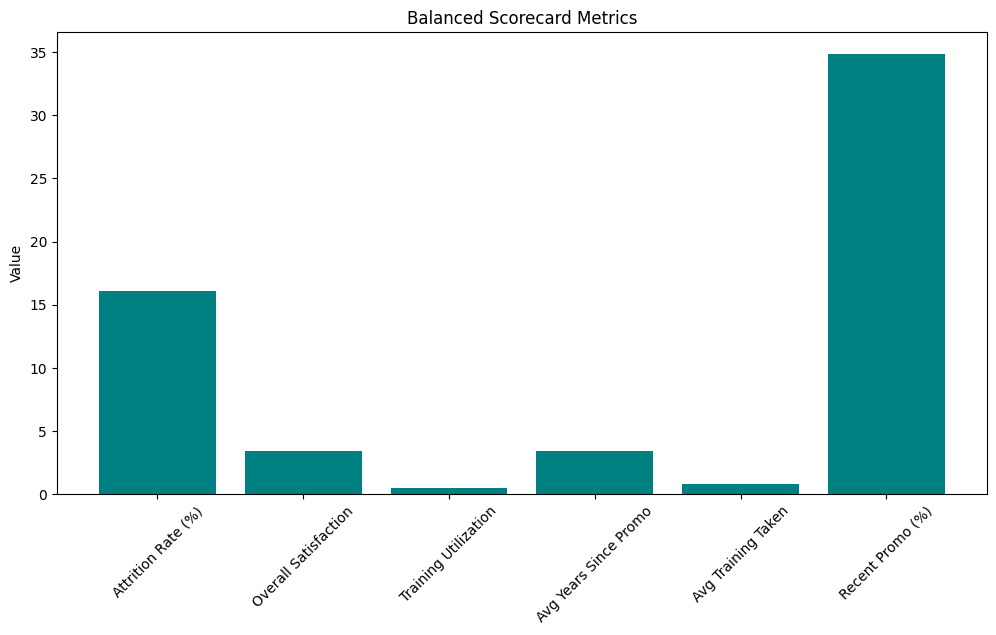

In [37]:
# Financial Perspective: Attrition Rate
attrition_rate = (employee_df['Attrition'] == 'Yes').mean() * 100
print(f"Attrition Rate: {attrition_rate:.2f}%")

# Employee Satisfaction: Average satisfaction scores
satisfaction_cols = ['EnvironmentSatisfaction', 'JobSatisfaction', 
                    'RelationshipSatisfaction', 'WorkLifeBalance']

# Some satisfaction columns might be in the performance_df or employee_df; adjust as needed
if set(satisfaction_cols).issubset(latest_performance.columns):
    latest_performance['OverallSatisfaction'] = latest_performance[satisfaction_cols].mean(axis=1)
    overall_satisfaction = latest_performance['OverallSatisfaction'].mean()
    print(f"Overall Average Satisfaction (1-5 scale): {overall_satisfaction:.2f}")
else:
    print("Satisfaction columns not found in latest performance data.")

# Internal Processes: Training Utilization and Years Since Last Promotion
if 'TrainingOpportunitiesWithinYear' in latest_performance.columns and 'TrainingOpportunitiesTaken' in latest_performance.columns:
    latest_performance['TrainingUtilization'] = (latest_performance['TrainingOpportunitiesTaken'] / latest_performance['TrainingOpportunitiesWithinYear'])
    avg_training_utilization = latest_performance['TrainingUtilization'].mean()
    print(f"Average Training Utilization: {avg_training_utilization:.2f}")
else:
    print("Training data not found in latest performance data.")

if 'YearsSinceLastPromotion' in employee_df.columns:
    avg_years_since_promo = employee_df['YearsSinceLastPromotion'].mean()
    print(f"Average Years Since Last Promotion: {avg_years_since_promo:.2f}")
else:
    print("Column 'YearsSinceLastPromotion' not found in employee data.")

# Learning and Growth: Training Opportunities Taken and Recent Promotions
if 'TrainingOpportunitiesTaken' in latest_performance.columns:
    avg_training_taken = latest_performance['TrainingOpportunitiesTaken'].mean()
    print(f"Average Training Opportunities Taken: {avg_training_taken:.2f}")
else:
    print("Column 'TrainingOpportunitiesTaken' not found in latest performance data.")

if 'YearsSinceLastPromotion' in employee_df.columns:
    recent_promo_pct = (employee_df['YearsSinceLastPromotion'] <= 1).mean() * 100
    print(f"Percentage of Employees with Promotion in Last Year: {recent_promo_pct:.2f}%")
else:
    print("Column 'YearsSinceLastPromotion' not found in employee data.")

# Optional: Visualize key metrics
metrics = {
    'Attrition Rate (%)': attrition_rate,
    'Overall Satisfaction': overall_satisfaction if 'overall_satisfaction' in locals() else np.nan,
    'Training Utilization': avg_training_utilization if 'avg_training_utilization' in locals() else np.nan,
    'Avg Years Since Promo': avg_years_since_promo if 'avg_years_since_promo' in locals() else np.nan,
    'Avg Training Taken': avg_training_taken if 'avg_training_taken' in locals() else np.nan,
    'Recent Promo (%)': recent_promo_pct if 'recent_promo_pct' in locals() else np.nan
}

plt.figure(figsize=(12, 6))
plt.bar(metrics.keys(), metrics.values(), color='teal')
plt.title('Balanced Scorecard Metrics')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.show()